<a href="https://colab.research.google.com/github/daquarti/AI/blob/main/Wordtovec_s%C3%ADntomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


Importo las librerias

In [ ]:
import pandas as pd
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import pickle
import random
import sys
from tqdm import tqdm

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Emergencias/Consultas/epicrisis_vmd.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759314 entries, 0 to 759313
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          759314 non-null  int64  
 1   id_ficha            759314 non-null  int64  
 2   id_incidente        759314 non-null  object 
 3   cierre_inst         759314 non-null  object 
 4   init_call_inst      759314 non-null  object 
 5   dni                 632174 non-null  float64
 6   paciente            759314 non-null  object 
 7   edad_paciente       757631 non-null  float64
 8   edad_unidad         759312 non-null  float64
 9   sexo_paciente       758961 non-null  object 
 10  pre_clasif          751516 non-null  object 
 11  post_clasif         759314 non-null  int64  
 12  traslado            232789 non-null  object 
 13  destino_final       526525 non-null  object 
 14  arbol               222192 non-null  object 
 15  epicrisis           719197 non-nul

In [ ]:
df.sample(20)

,Unnamed: 0,id_ficha,id_incidente,cierre_inst,init_call_inst,dni,paciente,edad_paciente,edad_unidad,sexo_paciente,pre_clasif,post_clasif,traslado,destino_final,arbol,epicrisis,diagnostico_nombre,lat_ryd,lon_ryd,cod_antecedente
715369,842922,1380967,15384706,2019-07-02 23:14:11.770,2019-07-02 21:17:10.870,21964348.0,Di Napoli Vanesa Alejandra,48.0,1.0,F,Verde,3,NaN,Domicilio con instrucciones,NaN,Paciente d 48 años\r\nSin antecedentes relevantes\r\nConsulta por sindrome gripal\r\nEcamen fisico sin relevancia,RESP Gripe (340),-34597900,-58413900,NaN
449607,536135,1369404,15371644,2019-06-30 05:38:59.597,2019-06-30 05:02:34.630,23672328.0,Kechichian Santiago,45.0,1.0,M,Verde,3,False,NaN,Calificó solicitante \r\n Solicita asistencia en Verde \r\n,NaN,RESP Infección respiratoria aguda del tracto superior (348),-34613119,-68338874,5
69945,97126,288577,14164094,2018-06-04 21:08:44.377,2018-06-04 10:06:19.630,54452821.0,Guzman Zoe Valentina,3.0,1.0,F,Verde,3,NaN,Domicilio con instrucciones,NaN,realizó tratamiento con amoxicilina por 7 días por dificultad respiratoria más catarro de vías aéreas superiores al examen físico sin signos de Bronco obstruccion afebril se encuentra de alta pautas de alarma,RESP Infección respiratoria aguda del tracto superior (348),-34664800,-58433200,NaN
39845,56530,279868,14150442,2018-05-31 12:11:59.537,2018-05-31 09:27:18.400,6877786.0,enrique butini,79.0,1.0,M,NaN,3,False,NaN,NaN,paciente beg refiere lumbalgia que se irradia a ambos mmii. el dolor se despierta con la maniobra de lassegue. se indica diclofenac im y derivacion a traumatologia,LOCOM Signos/síntomas lumbares (495),-32978700,-68784800,2|14|25
495578,589541,1346694,15347016,2019-06-24 12:17:55.133,2019-06-24 07:55:56.637,57636982.0,"AYALA, FELIPE AGUSTIN",2.0,1.0,M,Verde,3,NaN,Domicilio con instrucciones,NaN,paciente afebril estable activo refiere la mama que presenta cuadro de congestión nasal tos piel y mucosas hidratadas orofaringe sin particularidades aparato pulmonar con buena entrada de aire bilateral sin ruidos patológicos agregados con buena mecánica respiratoria abdomen ruidos hidroaéreos positivo blando depresible impresiona no doloroso a la palpación superficial ni profunda se dan indicaciones pautas de alarma y controles,RESP Gripe (340),-34677747,-58779192,NaN
462429,551409,1012957,15001776,2019-03-05 14:41:24.960,2019-03-05 13:55:06.333,41173576.0,Crespo Juan Cruz,20.0,1.0,M,Verde,3,NaN,Domicilio con instrucciones,NaN,Paciente masculino consulta por fiebre y malestar general \r\nAl momento orientado colaborador estable hemodinámicamente febril amigdalas hiperemicas hipertroficas csps ventilados,RESP Infección respiratoria aguda del tracto superior (348),-34575700,-58476300,NaN
307440,373219,682128,14672739,2018-10-20 19:27:35.340,2018-10-20 18:39:46.550,39801763.0,Spitale Nicolas,22.0,1.0,M,Verde,3,NaN,Domicilio con instrucciones,NaN,Refiere dolor molar inf izq afebril fr 18/min fc 80/min TA 110/70 INDIC.SINTOMATICO CONTROL POR ODONTOLOGIA,"DIGES Signos/síntomas de boca, lengua y labios (491)",-34818300,-58454300,NaN
538371,638778,847770,14843792,2018-12-23 13:03:26.013,2018-12-23 11:16:22.503,NaN,Marcolini Magdalena Susana,62.0,1.0,F,Verde,3,NaN,Domicilio con instrucciones,NaN,paciente afebril con tensión nerviosa,DERM Otros signos/síntomas de la piel y faneras (467),-34609500,-58396900,NaN
581334,688549,886458,14881184,2019-01-10 11:24:02.450,2019-01-10 10:09:12.247,18205188.0,Larroude Gladys,51.0,1.0,F,Verde,3,NaN,Domicilio con instrucciones,NaN,Hernia umbilical,DIGES Otros signos/síntomas del aparato digestivo (468),-34770900,-58351700,NaN
489377,582377,908817,14902019,2019-01-20 16:56:49.210,2019-01-20 12:52:04.457,NaN,Campos Carolina Candela,19.0,1.0,F,Verde,3,NaN,Domicilio con instrucciones,NaN,paciente refiere cuadro de dolor a la deglución y protrusión en zona cervical izquierda compatible con ganglio al examen físico eritema faríngeo abundante goteo retronasal adenomegalia dolorosa palpable a nivel cadena ganglionar cer

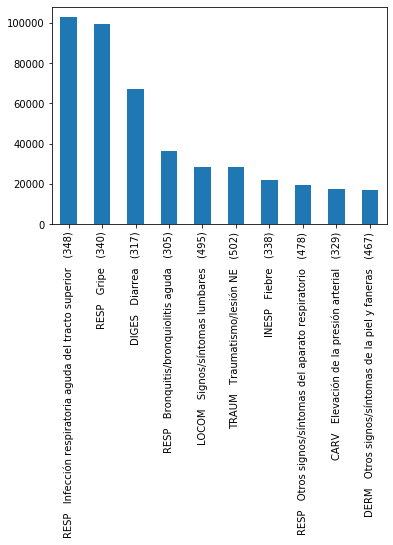

In [ ]:
df.diagnostico_nombre.value_counts().head(10).plot.bar()

In [ ]:
df.diagnostico_nombre.value_counts()

RESP   Infección respiratoria aguda del tracto superior   (348)                                  102872
RESP   Gripe   (340)                                                                             99616 
DIGES   Diarrea   (317)                                                                          67190 
RESP   Bronquitis/bronquiolitis aguda   (305)                                                    36508 
LOCOM   Signos/síntomas lumbares   (495)                                                         28584 
TRAUM   Traumatismo/lesión NE   (502)                                                            28348 
INESP   Fiebre   (338)                                                                           21745 
RESP   Otros signos/síntomas del aparato respiratorio   (478)                                    19257 
CARV   Elevación de la presión arterial   (329)                                                  17625 
DERM   Otros signos/síntomas de la piel y faneras   (467)       

In [ ]:
import re

In [ ]:
df.epicrisis.head(10)

0    Paciente. con sinusitis aguda                                                                                                                                                                                                                                                                                                                                             
1    Paciente femenina de 13 años, con traumatismo de cara anterior del cuello (pelotazo), atendido y trasladada por móvil 46 del 107 del municipio de Malvinas Argentinas.                                                                                                                                                                                                    
2    NaN                                                                                                                                                                                                                                                                

In [ ]:
df['corpus'] = df['epicrisis'].str.cat(sep=', ')

In [ ]:
#df.corpus.head(10)

In [ ]:
corpus = df['corpus'].values[0]

In [ ]:
import nltk
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sent_tokenize(corpus) 

['Paciente.',
 'con sinusitis aguda , Paciente femenina de 13 años, con traumatismo de cara anterior del cuello (pelotazo), atendido y trasladada por móvil 46 del 107 del municipio de Malvinas Argentinas., Paciente consulta por odinofagia y fiebre.',
 'Garganta con placas se indica antibióticos analgesia y se dejan pautas de alarma., Paciente quien refiere hace una hora presento mareo astenia adinamia niega otros sintomas niega signos de focalización neurologica antecedentes cardiovasculares ahora con ekg sin cambios significativos comparados con ekg reciente de enero 2018. en el momento no signos de isquemia cerebral se explica a familiar se dan amplias recomendaciones y signos de alarma , Paciente consulta por tos y odinofagia.',
 'Garganta congestiva sin placas se indica analgesia reposo y se dejan pautas de alarma., fiebre dolor de garganta .estaba tomando amox por su cuenta ,se rota a amox clavulanico.',
 'aine.',
 'mas control con otorrino, estable se deja indicaciones , yanina d

In [ ]:
corpus = corpus.replace("$"," signopesos ") 
# reemplazo numeros con " num " y  paso a minuscula 
reg_num = re.compile(r"\d+[.,]?\d*") # Regular expression to search numbers
corpus = reg_num.sub(" NUM ",corpus).lower()  
corpus = sent_tokenize(corpus)
# tiro los tokens no alphabeticos 
trainset = []
for sent in tqdm(corpus):
    tokens = []#corpus
    for token in word_tokenize(sent):
        if token.isalpha():
            tokens.append(token)
    trainset.append(tokens)

100%|██████████| 846287/846287 [02:33<00:00, 5503.62it/s]


In [ ]:
trainset[:2]

[['paciente'],
 ['con',
  'sinusitis',
  'aguda',
  'paciente',
  'femenina',
  'de',
  'num',
  'años',
  'con',
  'traumatismo',
  'de',
  'cara',
  'anterior',
  'del',
  'cuello',
  'pelotazo',
  'atendido',
  'y',
  'trasladada',
  'por',
  'móvil',
  'num',
  'del',
  'num',
  'del',
  'municipio',
  'de',
  'malvinas',
  'paciente',
  'consulta',
  'por',
  'odinofagia',
  'y',
  'fiebre']]

In [ ]:
print ("el corpus tiene",len(trainset), "oraciones y",sum([len(x) for x in trainset]),"palabras"   )

el corpus tiene 846287 oraciones y 21853393 palabras


In [ ]:
# filtro oraciones cortas
trainset2 = [] 
for sent in trainset:
    if len(sent)>3:
        trainset2.append(sent)

print( "el corpus tiene",len(trainset2), "oraciones y",sum([len(x) for x in trainset2]),"palabras"  )

el corpus tiene 663263 oraciones y 21467108 palabras


In [ ]:
# "window" es el tamaño de la ventana. windows = 10, usa 10 palabras a la izquierda y 10 palabras a la derecha
# "n_dim" es la dimension (i.e. el largo) de los vectores de word2vec
# "workers" es el numero de cores que usa en paralelo. Para aprobechar eso es necesario tener instalado Cython)
# "sample": word2vec filtra palabras que aparecen una fraccion mayor que "sample"
# "min_count": Word2vec filtra palabras con menos apariciones que  "min_count"
# "sg": para correr el Skipgram model (sg = 1), para correr el CBOW (sg = 0)
# para mas detalle ver: https://radimrehurek.com/gensim/models/word2vec.html
n_dim = 20
w2v_model = Word2Vec(trainset2, workers=4,size=n_dim, min_count = 10, window = 15, sample = 1e-3,negative=10,sg=1)

In [ ]:
import pickle

pickle.dump(w2v_model,open('/content/drive/My Drive/Emergencias/Consultas/epicrisis_vmd.w2v.pkl','wb'))

In [ ]:
import pickle

In [ ]:
modelo = pickle.load(open('/content/drive/My Drive/Emergencias/Consultas/epicrisis_vmd.w2v.pkl','rb'))

In [ ]:
modelo["piel"]  #representacion de una palabra

In [ ]:
modelo.most_similar(positive=["indico"], negative=[], topn=100)

In [ ]:
p_respi = ["tos","disfonía", "disnea", "faringitis", "nasal"]
p_gastro = ["epigastralgia","vomito","diarrea", "constipación", "pirosis", "defecar"]
p_neuro = ["cefalea","paresia", "insomnio", "mareos", "temblores"]
p_cardio = ["precordalgia", "palpitaciones", "síncope", "hipertenso"]
p_gineco = ["menstrual", "mama", "pélvico", "vaginal"]
p_psiquiatría = ["ansiedad", "depresión"]
p_fiebre = ["fiebre"]
p_dermato = ["papula", "prurito"]
p_otorrino = ["otitis", "hipoacusia", "epistaxis"]
p_traumato = ["traumatismo"]
p_uro = ["pene", "urinario"]
p_oftalmo = ["ocular"]
palabras = p_respi + p_gastro + p_neuro + p_cardio + p_gineco + p_psiquiatría + p_fiebre
colores = ["black"]*len(p_respi)+["blue"]*len(p_gastro)+["green"]*len(p_neuro)+["red"]*len(p_cardio)+["orange"]*len(p_gineco)+["cyan"]*len(p_psiquiatría)+["magenta"]*len(p_fiebre) 

In [ ]:
distancias=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias[i,j] = abs(1-modelo.wv.similarity(ti,tj))
print (distancias.shape)
distancias

In [ ]:
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 
def visualize_embeddings(distancias,palabras,colores,perplexity):
    plt.figure(figsize=(20,10))
    # Reduccion de la dimensionalidad y visualizacion 
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                       dissimilarity="precomputed", n_jobs=4)
    Y = mds.fit(distancias).embedding_
    plt.subplot(1,2,1)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("MDS")
    # Reduccion de la dimensionalidad y visualizacion 
    tsne = TSNE(n_components=2,metric="precomputed",learning_rate=1000, random_state=123,perplexity=perplexity)
    np.set_printoptions(suppress=True)
    plt.subplot(1,2,2)
    Y = tsne.fit_transform(distancias)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("TSNE")

In [ ]:
visualize_embeddings(distancias,palabras,colores,perplexity=10)

In [ ]:
print ("disena-torax similarity:",modelo.wv.n_similarity(["urinario"], ["fiebre"]))

In [ ]:
#sintomas = p_respi + p_cardio + p_fiebre + p_gastro + p_oftalmo + p_gineco + p_neuro + p_psiquiatría + p_uro + p_traumato + p_dermato + p_otorrino

In [ ]:
sintomas = ['apendice',
 'amenorrea',
 'gastritis',
 'vagina',
 'mialgias',
 'hematuria',
 'omalgia',
 'respiratorio',
 'blefaritis',
 'tobillo',
 'vertigo',
 'constipacion',
 'edemas',
 'parestesias',
 'oidos',
 'deposiciones',
 'ampollas',
 'dermatologia',
 'embarazo',
 'vomitos',
 'hipertension',
 'divertículos',
 'rinorrea',
 'diarrea',
 'craneo',
 'movilidad',
 'abdominal',
 'disuria',
 'sibilancias',
 'odinofagia',
 'cadera',
 'dispepsia',
 'rodilla',
 'maculas',
 'granos',
 'inconciente',
 'astenia',
 'fiebre',
 'mareo',
 'ansiedad',
 'traumatismo',
 'hipertenso',
 'ortopnea',
 'tos',
 'lumbalgia',
 'mama',
 'ojo',
 'insomnio',
 'coronario',
 'zumbidos',
 'cefalea',
 'conjuntivitis',
 'oliguria',
 'depresion',
 'pleural',
 'cardiovascular',
 'muñeca',
 'lipotimia',
 'disfonia',
 'hipoacusia',
 'prurito',
 'dislipemico',
 'precordalgia',
 'menstruacion',
 'fotofobia',
 'sinusitis',
 'osteocondritis',
 'articulaciones',
 'vaginitis',
 'disfagia',
 'hematoquecia',
 'cervicalgia',
 'erupcion',
 'infarto',
 'biliar',
 'eritema',
 'palpitaciones',
 'pirosis',
 'falange',
 'disnea',
 'polaquiuria',
 'fuma']

In [ ]:
target_word=""
similaridad = []
for word in sintomas:
    similaridad.append(modelo.wv.n_similarity([target_word], [word]))
    
sintomas_a_preguntar = pd.DataFrame(similaridad,index = sintomas,columns=[target_word]).sort_values(by=target_word, ascending = "True").plot(kind="bar",figsize=(15,5), fontsize=20)

In [ ]:
sintomas_similares = pd.DataFrame(similaridad,index = sintomas,columns=[target_word])

In [ ]:
sintomas_similares.sort_values(by = target_word, ascending = False).head(9).plot.bar()

In [ ]:
sintoms = sintomas_similares.sort_values(by = target_word, ascending = False)
  
  

In [ ]:
sintoms[sintoms.values > 0.70]

In [ ]:
lista = sintoms[sintoms.values > 0.75].index.values

In [ ]:
lista

In [ ]:
sintomas

In [ ]:
lista

In [ ]:
for s in lista:
  direccion = '/content/drive/My Drive/Emergencias/Consultas/' + s + '.json'
  f = open(direccion, "r")
  print(f.read())